In [47]:
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from pyjstat import pyjstat
import plotly.express as px

# Data Cleaning 
I start off by just testing out the eurostat dataset, then make functions for getting specific data for countries/types of crime and predicting the crime levels

In [48]:
def get_eurostat_data(article_title, *args):
    '''
    To Do:
        - Write *args
        - Write _url_builder() helper func.
    '''
    
    article_title = article_title.upper()
    url = f'https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{article_title}?format=JSON&lang=EN'

    output = pyjstat.Dataset.read(url)
    df = output.write('dataframe')

    return df

In [49]:
df_crime = get_eurostat_data("crim_off_cat")

In [50]:
df_crime.loc[:, "Time"] = df_crime.loc[:, "Time"].astype(int)
df_crime

,Time frequency,International classification of crime for statistical purposes (ICCS),Unit of measure,Geopolitical entity (reporting),Time,value
0,Annual,Intentional homicide,Number,Belgium,2008,204.00
1,Annual,Intentional homicide,Number,Belgium,2009,189.00
2,Annual,Intentional homicide,Number,Belgium,2010,189.00
3,Annual,Intentional homicide,Number,Belgium,2011,214.00
4,Annual,Intentional homicide,Number,Belgium,2012,206.00
...,...,...,...,...,...,...
25825,Annual,Participation in an organized criminal group,Per hundred thousand inhabitants,Kosovo*,2018,0.11
25826,Annual,Participation in an organized criminal group,Per hundred thousand inhabitants,Kosovo*,2019,0.17
25827,Annual,Participation in an organized criminal group,Per hundred thousand inhabitants,Kosovo*,2020,0.28
25828,Annual,Participation in an organized criminal group,Per hundred thousand inhabitants,Kosovo*,2021,NaN


In [51]:

df_crime = df_crime.rename(columns={"Geopolitical entity (reporting)" : "country"})


df_crime.loc[df_crime.country == "Türkiye", "country"] = "Turkey"
df_crime["International classification of crime for statistical purposes (ICCS)"].unique()


array(['Intentional homicide', 'Attempted intentional homicide',
       'Serious assault', 'Kidnapping', 'Sexual violence', 'Rape',
       'Sexual assault', 'Sexual exploitation', 'Child pornography',
       'Robbery', 'Burglary', 'Burglary of private residential premises',
       'Theft', 'Theft of a motorized vehicle or parts thereof',
       'Unlawful acts involving controlled drugs or precursors', 'Fraud',
       'Corruption', 'Bribery', 'Money laundering',
       'Acts against computer systems',
       'Participation in an organized criminal group'], dtype=object)

In [52]:
countries = "Austria, Belgium, Bulgaria, Croatia, Cyprus, Czechia, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, Sweden"
eu_countries = countries.split(", ")
eu_countries


['Austria',
 'Belgium',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Ireland',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden']

In [53]:
df_crime = df_crime[df_crime["country"].isin(eu_countries)]
df_homicide_be = df_crime[(df_crime.country == "Belgium") & (df_crime["Unit of measure"] == "Per hundred thousand inhabitants" ) & 
                                            (df_crime["International classification of crime for statistical purposes (ICCS)"] == "Intentional homicide")]





In [54]:
#get large dataset, clean it
df = get_eurostat_data("crim_off_cat")
df["Time"] = df["Time"].astype(int)

df = df.rename(columns={"Time" : "Year"})


#get EU countries
countries = "Austria, Belgium, Bulgaria, Croatia, Cyprus, Czechia, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, Sweden"
eu_countries = countries.split(", ")

#rename to country
df = df.rename(columns={"Geopolitical entity (reporting)" : "country", 
                        "value" : "Amount (Per 100k)"})

#change turkeys name
df.loc[df.country == "Türkiye", "country"] = "Turkey"

#include only EU countries
df = df[df["country"].isin(eu_countries)]


def get_crime_data(country, *args):
     if len(args) > 0:
          return df[(df.country == country) & (df["Unit of measure"] == "Per hundred thousand inhabitants" ) & 
                                            (df["International classification of crime for statistical purposes (ICCS)"] == args[0])]
     return df[(df.country == country) & (df["Unit of measure"] == "Per hundred thousand inhabitants" )]

    
    

In [55]:
df["International classification of crime for statistical purposes (ICCS)"].unique()

violent = ['Intentional homicide', 'Attempted intentional homicide',
       'Serious assault', 'Kidnapping']

sexual = ['Sexual violence', 'Rape',
       'Sexual assault', 'Sexual exploitation', 'Child pornography']

stealing = ['Robbery', 'Burglary', 'Burglary of private residential premises',
       'Theft', 'Theft of a motorized vehicle or parts thereof']

drugs = ['Unlawful acts involving controlled drugs or precursors']

white_collar = ['Fraud',
       'Corruption', 'Bribery', 'Money laundering',
       'Acts against computer systems',
       'Participation in an organized criminal group']

crime_categories = [violent, sexual, stealing, drugs, white_collar]

df_crime = get_eurostat_data("crim_off_cat")





In [56]:
crime_dict = {"country" : [], "violent" : [], "sexual" : [], "stealing" : [], "drugs" : [], "white_collar" : []}
#test = []


#so inefficient, but works (could optimize but already had get_crime_data method written)
for country in eu_countries:

    crime_dict["country"].append(country)
    i = 0
    for category in crime_categories:
       
       sum = 0;
       crime_bool = (df_crime["International classification of crime for statistical purposes (ICCS)"] == category[0])
       for crime in category[1:]:
            crime_bool = (crime_bool) | (df_crime["International classification of crime for statistical purposes (ICCS)"] == crime)
        
        
       crime_bool = (crime_bool) & (df.country == country) & (df["Unit of measure"] == "Per hundred thousand inhabitants" ) & (df_crime["Time"] == "2022")
       
       df_category_crime = df_crime[crime_bool]

       #if df_category_crime.shape != df_category_crime.dropna().shape :
           #test.append(country)
           #print(category[0])
           
       crime_dict[list(crime_dict.keys())[i + 1]].append(df_category_crime["value"].sum())
       i += 1

pd.DataFrame(crime_dict)

,country,violent,sexual,stealing,drugs,white_collar
0,Austria,50.47,131.76,1764.21,392.39,1074.51
1,Belgium,572.04,202.26,2664.35,484.04,1141.27
2,Bulgaria,48.77,17.53,575.33,78.32,45.17
3,Croatia,23.74,52.32,592.68,237.81,172.74
4,Cyprus,22.87,31.72,203.05,113.30,70.62
5,Czechia,41.03,43.48,754.10,39.94,203.97
6,Denmark,40.12,271.67,3468.77,532.38,1133.53
7,Estonia,6.39,49.48,656.56,235.02,235.62
8,Finland,38.94,201.32,2560.43,454.31,1096.18
9,France,583.80,270.45,2500.81,488.82,417.65


Now, I'm showing an individual data set's graph

In [57]:
crime_data = get_crime_data("Austria", 'Intentional homicide')
print(crime_data)
px.scatter(data_frame=crime_data, x="Year", y="Amount (Per 100k)")


    Time frequency  \
900         Annual   
901         Annual   
902         Annual   
903         Annual   
904         Annual   
905         Annual   
906         Annual   
907         Annual   
908         Annual   
909         Annual   
910         Annual   
911         Annual   
912         Annual   
913         Annual   
914         Annual   

    International classification of crime for statistical purposes (ICCS)  \
900                               Intentional homicide                      
901                               Intentional homicide                      
902                               Intentional homicide                      
903                               Intentional homicide                      
904                               Intentional homicide                      
905                               Intentional homicide                      
906                               Intentional homicide                      
907                            

Now, I'm going to add up all the crime per country, per year. Because each crime is in the per 100k units, i can simply add them up to get the total amount of crimes per 100k for a given country for a given year

In [58]:

df_crime_100k = df_crime[ df_crime["Unit of measure"] == "Per hundred thousand inhabitants" ]
df_crime_100k_nona = df_crime_100k.dropna()


country_lst = []
year_lst = []
amount = []
for country in eu_countries:
    df_country = get_crime_data(country)
    min = df_country["Year"].min()
    max = df_country["Year"].max()

    df_crime_country = pd.DataFrame()
    
    for year in range(min, max + 1):
        df_country_year = df_country[df_country["Year"] == year]
        sum = df_country_year["Amount (Per 100k)"].sum()
        country_lst.append(country)
        year_lst.append(year)
        amount.append(sum)
    

df_total_crime = pd.DataFrame({"country" : country_lst, "year" : year_lst, "amount" : amount})
df_total_crime.loc[df_total_crime.country == "Czechia", "country"] = "Czech Republic"

print(df_total_crime)


#print(df_total_crime.corr() )
px.scatter(df_total_crime, x="year", y="amount", color="country")

df_total_crime.to_csv("../Phase 3/Data/crime_training.csv", index=False)

     country  year   amount
0    Austria  2008  3896.74
1    Austria  2009  3906.74
2    Austria  2010  3308.21
3    Austria  2011  3197.13
4    Austria  2012  3212.19
..       ...   ...      ...
400   Sweden  2018  9620.21
401   Sweden  2019  9423.61
402   Sweden  2020  9299.21
403   Sweden  2021  8730.09
404   Sweden  2022  8482.97

[405 rows x 3 columns]


# Time to Scale it!!

In [60]:

mean = df_total_crime.describe()["amount"]["mean"]

std = df_total_crime.describe()["amount"]["std"]




df_total_crime_scaled = pd.DataFrame()

df_total_crime_scaled["country"] = df_total_crime["country"]
df_total_crime_scaled["year"] = df_total_crime["year"]

df_total_crime_scaled["amount"] = (df_total_crime["amount"] - mean) / std

df_total_crime_scaled.loc[df_total_crime_scaled.country == "Czechia", "country"] = "Czech Republic"



px.scatter(df_total_crime_scaled, x="year", y="amount", color="country")

In [61]:


df_total_crime_dummies = df_total_crime_scaled.join(pd.get_dummies(df_total_crime_scaled["country"], drop_first=True, dtype='int'))
crime_arr = np.array(df_total_crime_dummies.drop(columns=["country"]))
crime_arr


array([[2.00800000e+03, 6.50709674e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00900000e+03, 6.55852784e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.01000000e+03, 3.48022200e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.02000000e+03, 3.42925961e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.02100000e+03, 3.13655491e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.02200000e+03, 3.00945837e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [62]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

def line_of_best_fit(X, y):
    X = add_bias_column(X)
    return np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))



In [63]:
X_left = crime_arr[:, 0:1]
X_right = crime_arr[:, 2:]

X = np.hstack((X_left, X_right))

y = crime_arr[:, 1:2]


#print(X)
#print(y)


#regression line for all crime data
regression = line_of_best_fit(X, y)

#test add
np.dot(add_bias_column(X)[0, :], regression)
regression


array([[ 5.14926407e+01],
       [-2.53432103e-02],
       [ 8.42471648e-01],
       [-1.26915094e+00],
       [-1.20488126e+00],
       [-1.37959101e+00],
       [-8.56628574e-01],
       [ 1.90978637e+00],
       [-8.90212055e-01],
       [ 2.66772448e-01],
       [ 2.22774168e-01],
       [-3.16651018e-02],
       [-9.88223281e-01],
       [-9.07221350e-01],
       [-3.66568333e-01],
       [-3.60252936e-01],
       [-1.08592283e+00],
       [-1.19885834e+00],
       [ 1.58118413e-01],
       [-6.81031129e-01],
       [ 1.11259878e-01],
       [-1.15802787e+00],
       [-8.01915823e-01],
       [-1.40611505e+00],
       [-1.36041955e+00],
       [-6.50616488e-01],
       [-9.25997474e-01],
       [ 2.50817285e+00]])

In [69]:
#add regression to csv for DB
regression_db_dict = {"intercept" : regression[0], "slope" : regression[1]}
country_keys = pd.get_dummies(df_total_crime_scaled["country"], drop_first=True, dtype='int').keys()

for index in range(len(country_keys)):
    regression_db_dict[country_keys[index]] = regression[index + 2]

regression_db_dict["mean"] = [df_total_crime["amount"].mean()]
regression_db_dict["std"] = [df_total_crime["amount"].std()]

pd.DataFrame(regression_db_dict).to_csv("../Phase 3/Data/crime_inference.csv")

In [ ]:
y_preds = np.matmul(add_bias_column(X), regression)
resids = y - y_preds


Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


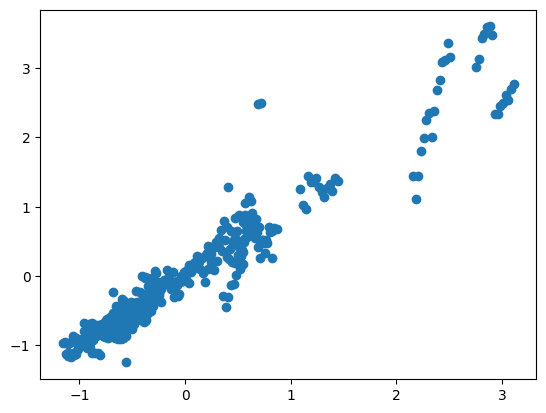

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_preds, y)

In [ ]:
def lin_reg_crime (country, year):
    """
    following linear regression model, predicts the total amount of crimes per 100k people

    Args:
       - country (int) - which country wanted for prediction
       - year (int) - which year we wanted for prediction

    Returns:
       - answer (int) - predicted value for crimes per 100k people
    
    """
    countries = df_total_crime_dummies.keys().to_list()[3:]

    encoding = [0] * len(countries)

    encoding[countries.index(country)] = 1

    encoding.insert(0, year)
    encoding.insert(0, 1)

    scaled_answer = np.matmul(encoding, regression)[0]




    answer = scaled_answer * std + mean

    return answer

lin_reg_crime("Sweden", 2040) 

7104.827707686182

In [ ]:
df_total_crime_dummies

,country,year,amount,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech Republic,Denmark,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
0,Austria,2008,0.650710,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Austria,2009,0.655853,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Austria,2010,0.348022,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Austria,2011,0.290893,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Austria,2012,0.298638,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,Sweden,2018,3.594353,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
401,Sweden,2019,3.493240,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
402,Sweden,2020,3.429260,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
403,Sweden,2021,3.136555,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
import matplotlib.pyplot as plt
def plot_residuals_predictions(ypreds, resids):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(ypreds, resids)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted Values')

    plt.subplot(1, 2, 2)
    plt.plot(resids, marker='o', linestyle='none')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Index Order')

    plt.tight_layout()
    plt.show()


# Preparing the dataset for regression
X = df_total_crime_dummies.drop(columns=['amount', 'country']).values
y = df_total_crime_dummies['amount'].values

# Compute the regression coefficients
regression = line_of_best_fit(X, y)

# Make predictions
X_with_bias = add_bias_column(X)
ypreds = np.dot(X_with_bias, regression)

# Calculate residuals
resids = y - ypreds

# Make predictions
X_with_bias = add_bias_column(X)
ypreds = np.dot(X_with_bias, regression)

# Calculate residuals
resids = y - ypreds

plot_residuals_predictions(ypreds, resids)

ModuleNotFoundError: No module named 'matplotlib'

The plots above may be used to validate the assumptions of a linear regression on the model made here. In the left plot, which maps Residuals to Predicted Values, the residuals do appear to show some curvature, which suggests that the relationship between the independent and dependent variables may not be linear. This plot may also be used to assess the assumption of homoskedasticity. As the points appear to be relatively randomly placed (lacking a strong trending direction), the model seems to meet this assumption. This means that the variance of error is constant across the model. The right plot, showing Residuals vs Index Order, shows no clear pattern in the residuals, which suggests that the assumption of independence is likely met.

# Leisure Activities

In [ ]:
df_leisure = get_eurostat_data("ilc_scp01")
df_leisure["Age class"].unique()

In [ ]:
df_leisure[(df_leisure["Age class"] == "16 years or over") & (df_leisure["Sex"] == "Total") & (df_leisure["Frequency"] == "At least once") 
           & (df_leisure["Time"] == "2022") & (df_leisure["Geopolitical entity (reporting)"].isin(eu_countries)) & (df_leisure["International Standard Classification of Education (ISCED 2011)"] == "All ISCED 2011 levels")]


In [ ]:
age_classes = [(16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74), 75]
df_leisure_subset = df_leisure[(df_leisure["Sex"] == "Total") & (df_leisure["Frequency"] == "At least once") 
           & (df_leisure["Time"] == "2022") & (df_leisure["Geopolitical entity (reporting)"].isin(eu_countries)) & (df_leisure["International Standard Classification of Education (ISCED 2011)"] == "All ISCED 2011 levels")]

leisure_by_age = pd.DataFrame()
leisure_dict = {"country" : df_leisure_subset["Geopolitical entity (reporting)"].unique().tolist()}

for ages in age_classes:
    if type(ages) is int:
        temp = df_leisure_subset[df_leisure_subset["Age class"] == f'{ages} years or over']["value"].tolist()
        leisure_dict[f'leisure_{ages}_older'] = temp
    else:
        temp = df_leisure_subset[df_leisure_subset["Age class"] == f'From {ages[0]} to {ages[1]} years']["value"].tolist()
        leisure_dict[f'leisure_{ages[0]}_{ages[1]}'] = temp
    

    
    
    

leisure_df = pd.DataFrame(leisure_dict)
leisure_df.loc[leisure_df.country == "Czechia", "country"] = "Czech Republic"
leisure_df


    

    
    

Ages classes: 16-24, 25-34, 35-44, 45-54, 55-64, 65-74, 75+

Units: percentage